<p style="font-weight:bold;font-size:200%"> Txn </p>

- Author: Yichen
- Date: 20220911

In [2]:
import pandas as pd
import threading
import requests
import time
import os
import datetime
import re
import string
import random
import numpy as np
import seaborn as sns;sns.set_theme(color_codes=True)
import warnings
from web3 import Web3
from hexbytes import HexBytes

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from IPython.core.interactiveshell import InteractiveShell
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)
warnings.filterwarnings("ignore")


RD = '/home/team_defi/02_rdata/'
WD = '/home/team_defi/03_wdata/'
RES = '/home/team_defi/04_result/'
InteractiveShell.ast_node_interactivity = 'all'

# Function

In [80]:
def liquidity_provision(transaction_id, chain):
    
    time.sleep(random.random() * 2)
    headers = {'user-agent':'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.75 Safari/537.36'}

    if chain == 'ethereum': url = f'https://etherscan.io/tx/{transaction_id}'
    if chain == 'binance' : url = f'https://bscscan.com/tx/{transaction_id}'
    if chain == 'avalanche': url = f'https://snowtrace.io/tx/{transaction_id}'
    if chain == 'polygon' : url = f'https://polygonscan.com/tx/{transaction_id}'
    if chain == 'fantom' : url = f'https://ftmscan.com/tx/{transaction_id}'

    r = requests.get(url, headers=headers)
    if re.search('liquidity to', r.text.lower()) != None:
        return True
    else:
        return False

In [18]:
def set_buy(df):

    
    for idx, row in df.iterrows():
        index = row['id']
        insider_contractAddress = row['insider_contractAddress'].lower()
        token0_id = row['token0_id'].lower()
        token1_id = row['token1_id'].lower()

        amount0Out = row['amount0Out']
        amount0In = row['amount0In']
        amount1Out = row['amount1Out']
        amount1In = row['amount1In']
        amountUSD = row['amountUSD']

        if insider_contractAddress == token0_id:
            if (amount0In == 0)|(amount1Out == 0):
                df.loc[df['id'] == index, 'buy'] = amountUSD
            else:
                df.loc[df['id'] == index, 'buy'] = - amountUSD

        else:
            if (amount0In == 0)|(amount1Out == 0):
                df.loc[df['id'] == index, 'buy'] = - amountUSD
            else:
                df.loc[df['id'] == index, 'buy'] = amountUSD
            
    return df

# Merge Price Impact

## Crash Old: Log Return

In [32]:
it = pd.read_csv(f'{WD}/daily_transaction/list/panel.csv')
it.loc[it['contractAddress'] == '0x506d62bf7d8a8f444f13533081dc03470483f4ea']

,Unnamed: 0,amountUSD,id,logIndex,origin,recipient,sender,sqrtPriceX96,tick,timestamp,token0_name,token1_name,token0_id,token1_id,transaction_id,amount0Out,amount0In,amount1Out,amount1In,home_token,dex,chain,insider_root,contractAddress,from,to,lp,buy,ret_1,ret_2,ret_3,ret_-1,ret_-2,ret_-3,date,panels,insider_layer_one,insider_Address
174,97.0,8452.072967,0x0307bab03f362be04fc6dd9c51130b1def0fcc8587432c6b5a4da6a6b65cd38c-0,81,NaN,NaN,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,NaN,NaN,2021-07-31 08:15:29,t.me/skin_port,Wrapped Ether,0x506d62bf7d8a8f444f13533081dc03470483f4ea,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x0307bab03f362be04fc6dd9c51130b1def0fcc8587432c6b5a4da6a6b65cd38c,0.0,2.446630e+15,6.882143,0.0,True,uniswapv2_ethereum,ethereum,0x6e86c831b85cc37f0aeeb5d553c40b257af8fb42,0x506d62bf7d8a8f444f13533081dc03470483f4ea,0x6e86c831b85cc37f0aeeb5d553c40b257af8fb42,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,False,-8452.072967,NaN,NaN,NaN,NaN,NaN,NaN,2021-07-31,root,NaN,NaN


In [102]:
pd.set_option('display.max_rows', None)
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv')
df_crash = df.loc[(df['crash_0'] == 1)&(df['insider_trading'] == True)]
df_crash['avg_priceImpact'] = np.nan
it = pd.read_csv(f'{WD}/daily_transaction/list/panel.csv')

for _, row_df_crash in df_crash.drop_duplicates(['contractAddress', 'chain']).iterrows():
    contractAddress = row_df_crash['contractAddress']
    contractAddress_lower = contractAddress.lower()
    contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
    chain = row_df_crash['chain']
    crashes = df_crash.loc[(df_crash['contractAddress'] == contractAddress)&(df_crash['chain'] == chain)]
    
    for _, row_crashes in crashes.drop_duplicates('date').iterrows():
        ret_0 = row_crashes['ret_0']
        date = row_crashes['date']
        its = it.loc[((it['contractAddress'] == contractAddress_lower)&(it['date'] == date))|
                     ((it['contractAddress'] == contractAddress_upper)&(it['date'] == date))]
        roles = {i for i in its['panels'].values}
        for role in roles:
            avg_priceImpacts = 0
            priceImpacts = 0
            dexes = {i for i in its.loc[its['panels'] == role, 'dex'].values}
            dex_num = 0
            for dex in dexes:
                lst = pd.read_csv(f'{WD}daily_transaction/list/{dex}.csv')
                status = lst.loc[(lst['contractaddress'] == contractAddress_lower)&(lst['date'] == date), 'status'].values[0]
                if status != -1:
                    dex_num += 1
                    t = pd.read_csv(f'{WD}daily_transaction/csv/{contractAddress_lower}_{date}_{dex}.csv')
                    for _, row_its in its.loc[(its['dex'] == dex)&(its['panels'] == role)].iterrows():
                        ID = row_its['id']
                        timestamp = row_its['timestamp']
                        token0_id = row_its['token0_id']
                        token1_id = row_its['token1_id']
                        amountUSD = row_its['amountUSD']
                        amount0Out = row_its['amount0Out']
                        amount0In = row_its['amount0In']
                        amount1Out = row_its['amount1Out']
                        amount1In = row_its['amount1In']

                        if (token0_id == contractAddress_lower)|(token0_id == contractAddress_upper): tokenPrice = amountUSD / np.abs(amount0Out - amount0In)
                        else: tokenPrice = amountUSD / np.abs(amount1Out - amount1In)

                        t.sort_values('timestamp', ascending=True, inplace=True)
                        last = t.loc[(t['timestamp'] < timestamp)].tail(1)

                        # If the insider trading is the first transaction

                        if len(last) != 0:
                            token0_id_last = last['token0_id'].values[0]
                            token1_id_last = last['token1_id'].values[0]
                            amountUSD_last = last['amountUSD'].values[0]
                            amount0Out_last = last['amount0Out'].values[0]
                            amount0In_last = last['amount0In'].values[0]
                            amount1Out_last = last['amount1Out'].values[0]
                            amount1In_last = last['amount1In'].values[0]

                            if (token0_id_last == contractAddress_lower)|(token0_id_last == contractAddress_upper): tokenPrice_last = amountUSD_last / np.abs(amount0Out_last - amount0In_last)
                            else: tokenPrice_last = amountUSD_last / np.abs(amount1Out_last - amount1In_last)

                        else:

                            # If the priceUSD is nan, just leave it error

                            date_last = (pd.to_datetime(date) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
                            tokenPrice_last = df.loc[(df['date'] == date_last)&(df['contractAddress'] == contractAddress), 'priceUSD'].values[0]

                        priceImpact = (np.log(tokenPrice) - np.log(tokenPrice_last)) / ret_0
                        
                        priceImpacts += priceImpact    
                else:
                    print(f'{dex} have no daily transaction info')
                    continue

            if dex_num == 0:
                print(f'{contractAddress} have no data')
                continue
            else:
                avg_priceImpacts = priceImpacts / dex_num
                df_crash.loc[(df_crash['contractAddress'] == contractAddress)&(df_crash['chain'] == chain)&(df_crash['date'] == date)&(df_crash['panel'] == role), 'avg_priceImpact'] = avg_priceImpacts
                print(f'{role} of {contractAddress} on {chain} at {date} have a price impact of {avg_priceImpacts}')

root of 0x506d62bf7d8a8f444f13533081dc03470483f4ea on ethereum at 2021-07-31 have a price impact of 0.5247517786145943
root of 0x834806a97938ae7270d3dfef01240206b380e716 on ethereum at 2021-08-11 have a price impact of 0.05400624471964534
root of 0x19cc01205453020455f6e068632daf9d7790ca61 on ethereum at 2021-09-27 have a price impact of 0.532734819746974
root of 0x443c31b525791b4bfb1cf67196475cb27b834b67 on ethereum at 2021-11-03 have a price impact of 0.032263139495684524
whale_new of 0x443c31b525791b4bfb1cf67196475cb27b834b67 on ethereum at 2021-11-03 have a price impact of -0.032770706693661104
root of 0x985572429deb3acc47e019af6b3da4620175e553 on ethereum at 2022-02-14 have a price impact of 0.4887094360740413
root of 0x0c4ba8e27e337c5e8eac912d836aa8ed09e80e78 on ethereum at 2022-05-03 have a price impact of 0.0063320820160149135
root of 0x55e558b46386521ecea9aca3634043d0c8458fbd on ethereum at 2022-04-11 have a price impact of 0.9484814071431436
root of 0xe9fba30ff18d305fea4983693

### Analysis

In [83]:
pd.set_option('display.max_rows', 20)
df_crash

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,panel,insider_trading,insider_buy,insider_sell,twitter,event_date_-5,event_date_-4,event_date_-3,event_date_-2,event_date_-1,event_date_0,event_date_1,event_date_2,event_date_3,event_date_4,event_date_5,crash_new,crash_-5,crash_-4,crash_-3,crash_-2,crash_-1,crash_0,crash_1,crash_2,crash_3,crash_4,crash_5,avg_priceImpact
5162,2021-07-31,0x506d62bf7d8a8f444f13533081dc03470483f4ea,ethereum,NaN,NaN,NaN,NaN,NaN,-21.945898,NaN,NaN,NaN,NaN,NaN,1.000000e-16,root,True,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.524752
6170,2021-08-11,0x834806a97938ae7270d3dfef01240206b380e716,ethereum,NaN,NaN,NaN,NaN,NaN,-6.846932,NaN,NaN,NaN,NaN,NaN,1.888832e+00,root,True,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.054006
8779,2021-09-27,0x19cc01205453020455f6e068632daf9d7790ca61,ethereum,NaN,NaN,NaN,NaN,NaN,-21.084023,NaN,NaN,NaN,NaN,NaN,5.004000e-13,root,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.532735
11102,2021-11-03,0x443c31b525791b4bfb1cf67196475cb27b834b67,ethereum,NaN,NaN,NaN,NaN,NaN,-3.064651,-0.060249,-0.065659,-0.074253,NaN,NaN,8.076939e-05,root,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.032263
15431,2022-02-14,0x985572429deb3acc47e019af6b3da4620175e553,ethereum,0.036964,-0.319194,-0.110819,-0.118688,-0.019601,-2.070151,NaN,NaN,NaN,NaN,NaN,9.453312e-04,root,True,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.488709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324740,2022-03-01,0x55c26094d55baD3fa61584901DD3C4680e7064d4,binance,NaN,NaN,NaN,NaN,NaN,-1.273588,-0.170949,-0.444706,0.027911,-0.045667,-0.116289,2.626963e-05,whale_new,True,True,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,NaN
325015,2022-06-16,0x17ee01A173fE03863CDBFB1799E082eaA96e2049,binance,NaN,NaN,NaN,NaN,NaN,-3.594999,NaN,NaN,NaN,NaN,NaN,3.849509e-04,whale_new,True,True,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,NaN
325622,2022-02-14,0x1D4Cc4d9dd63BEF2a0e313687628f109e32C59B2,binance,NaN,NaN,NaN,NaN,NaN,-1.215055,0.191907,0.963522,0.831550,0.976920,0.065216,1.058299e+01,whale_new,True,True,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,NaN
330748,2021-08-05,0xC29d5E838fEBad1ae72010405DDDEA7a2b1aCf25,binance,1.896518,-0.549790,0.937896,-0.275753,-0.050748,-1.361590,-0.205356,-0.085455,-0.305552,NaN,NaN,9.599316e-08,whale_new,True,True,True,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,NaN


<AxesSubplot:>

count    16.000000
mean      0.635806
std       0.346724
min       0.006332
25%       0.473424
50%       0.658221
75%       0.949828
max       1.047188
Name: avg_priceImpact, dtype: float64

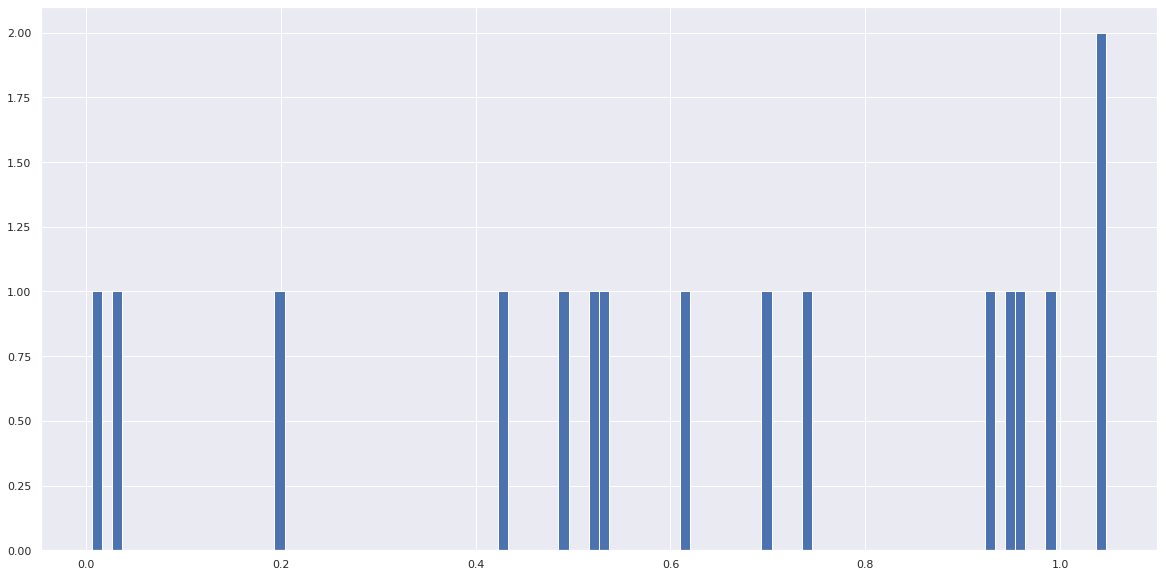

<AxesSubplot:>

count    15.000000
mean      0.273881
std       0.290879
min       0.018428
25%       0.065460
50%       0.243044
75%       0.324487
max       1.136349
Name: avg_priceImpact, dtype: float64

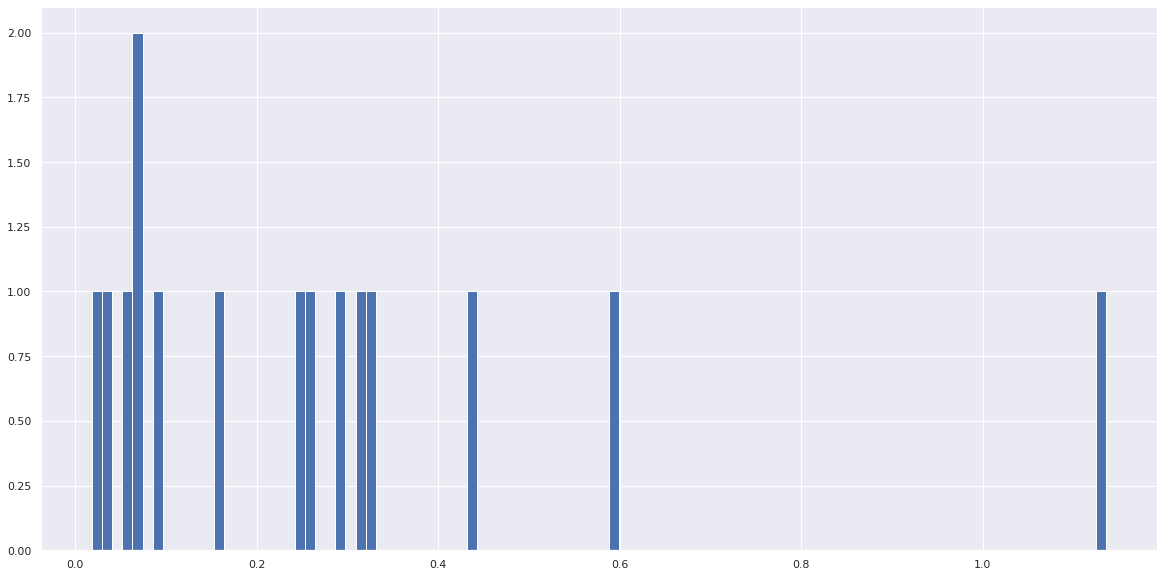

<AxesSubplot:>

count    22.000000
mean      0.453145
std       0.262345
min      -0.006791
25%       0.319959
50%       0.526708
75%       0.548203
max       1.035744
Name: avg_priceImpact, dtype: float64

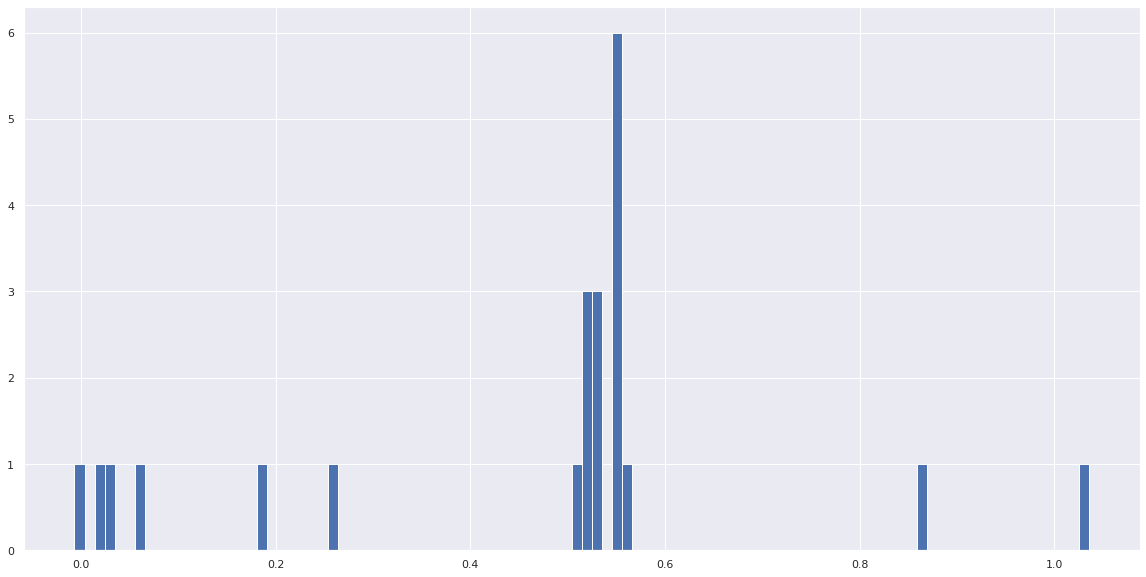

In [103]:
ana = df_crash.copy()
for role in ['root', 'layer_one', 'whale_new']: 
    ana.loc[(ana['panel'] == role)&(ana['insider_sell'] == True)&(ana['insider_buy'] == False), 'avg_priceImpact'].hist(figsize=(20, 10), bins=100)
    ana.loc[(ana['panel'] == role)&(ana['insider_sell'] == True)&(ana['insider_buy'] == False), 'avg_priceImpact'].describe()
    plt.show()

<AxesSubplot:>

count    4.000000
mean    -0.208477
std      0.440871
min     -0.868165
25%     -0.226521
50%     -0.010340
75%      0.007703
max      0.054936
Name: avg_priceImpact, dtype: float64

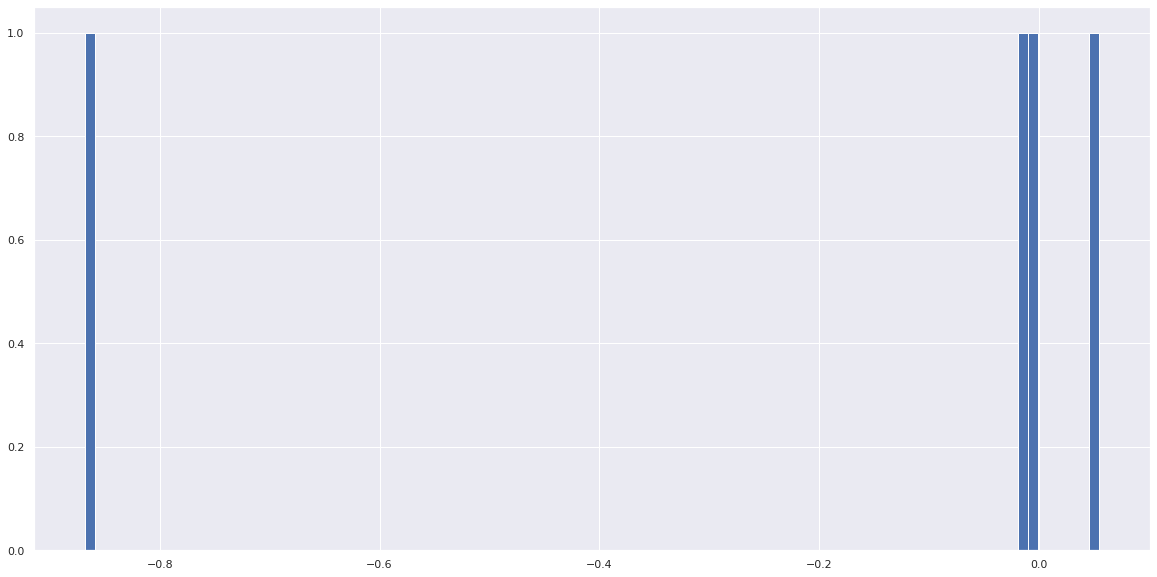

<AxesSubplot:>

count    2.000000
mean    -0.005676
std      0.007698
min     -0.011119
25%     -0.008398
50%     -0.005676
75%     -0.002954
max     -0.000233
Name: avg_priceImpact, dtype: float64

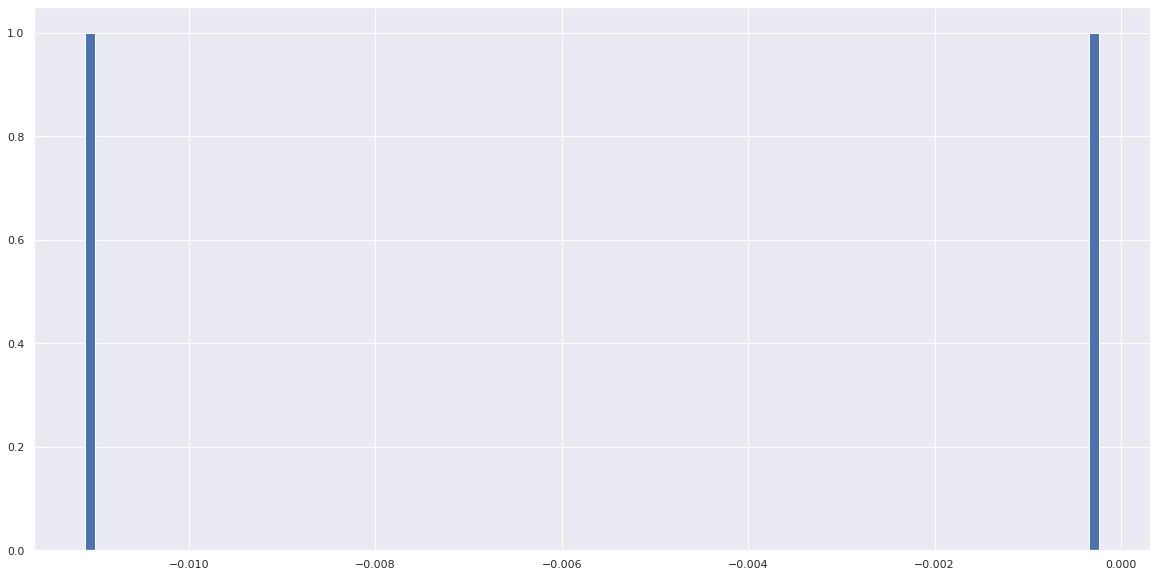

<AxesSubplot:>

count    125.000000
mean      -0.109655
std        0.148995
min       -1.200019
25%       -0.140656
50%       -0.075075
75%       -0.033540
max        0.206847
Name: avg_priceImpact, dtype: float64

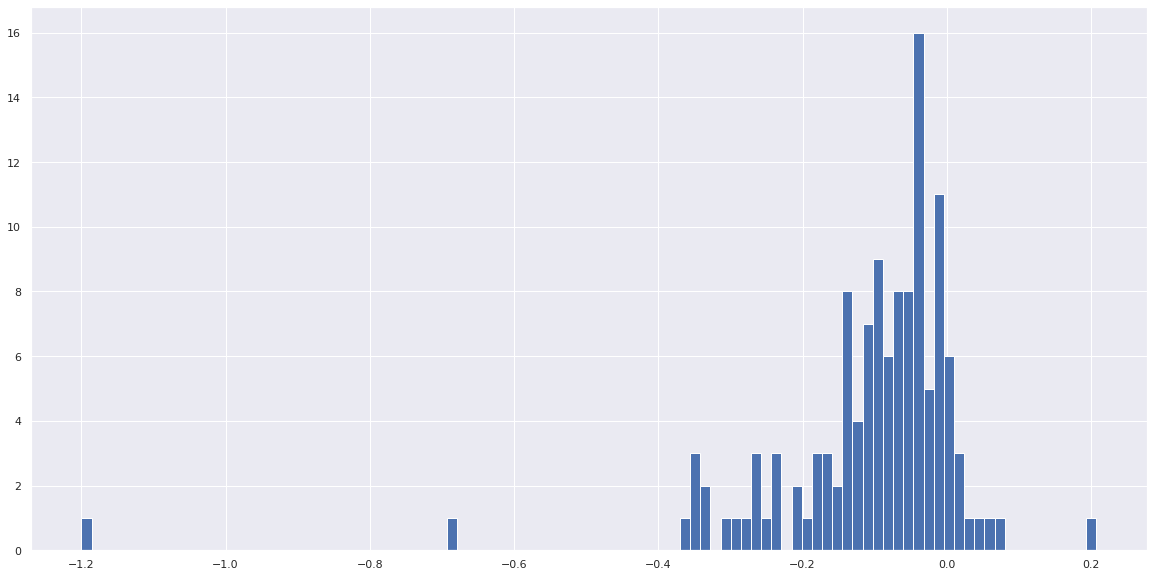

In [104]:
for role in ['root', 'layer_one', 'whale_new']: 
    ana.loc[(ana['panel'] == role)&(ana['insider_buy'] == True)&(ana['insider_sell'] == False), 'avg_priceImpact'].hist(figsize=(20, 10), bins=100)
    ana.loc[(ana['panel'] == role)&(ana['insider_buy'] == True)&(ana['insider_sell'] == False), 'avg_priceImpact'].describe()
    plt.show()

In [105]:
os.getcwd()

'/home/team_defi/01_code'

In [131]:
pd.set_option('display.max_rows', None)
ana.loc[(ana['panel'] == 'whale_new')&(ana['insider_sell'] == True)&(ana['avg_priceImpact'] > 0.4)]

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,panel,insider_trading,insider_buy,insider_sell,twitter,event_date_-5,event_date_-4,event_date_-3,event_date_-2,event_date_-1,event_date_0,event_date_1,event_date_2,event_date_3,event_date_4,event_date_5,crash_new,crash_-5,crash_-4,crash_-3,crash_-2,crash_-1,crash_0,crash_1,crash_2,crash_3,crash_4,crash_5,avg_priceImpact
155671,2021-08-03,0x708d6B8142897372e4F956252d1407192c22F2F7,ethereum,NaN,NaN,NaN,NaN,NaN,-24.488595,NaN,NaN,NaN,NaN,NaN,9.000000e-16,whale_new,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.420917
156468,2021-08-13,0x38163700ccE1474195D4DA86aC5A6679aFC31378,ethereum,NaN,NaN,NaN,NaN,-0.025888,-25.274625,NaN,NaN,NaN,NaN,NaN,8.000000e-16,whale_new,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.433581
159265,2021-09-06,0x2c720daB5968c7cB72De2ccC05248EC938cD398E,ethereum,NaN,NaN,NaN,NaN,NaN,-28.920307,NaN,NaN,NaN,NaN,NaN,1.000000e-16,whale_new,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.486829
159620,2021-09-12,0x2E685fD48ecB0b4EE7aA3e4Ba0FBd31bE73A5283,ethereum,NaN,NaN,NaN,NaN,NaN,-29.454257,NaN,NaN,NaN,NaN,NaN,1.000000e-16,whale_new,True,True,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.497484
163557,2021-10-10,0xe77ab9BCaBDEF9e8c972ac3037F44C5A220d1eD0,ethereum,NaN,NaN,NaN,NaN,0.629194,-28.655229,NaN,NaN,NaN,NaN,NaN,2.000000e-16,whale_new,True,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.488695
170862,2021-11-01,0x33824827A6cdb3F2f00c1F6CEC8F6DF2B3D233fe,ethereum,NaN,NaN,NaN,NaN,NaN,-25.159163,NaN,NaN,NaN,NaN,NaN,1.070000e-14,whale_new,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.432334
174874,2021-11-11,0x65f93FA32C1D2b7F29ff5f3a3B4BE0fB9991084d,ethereum,NaN,NaN,NaN,NaN,NaN,-30.677179,NaN,NaN,NaN,NaN,NaN,1.000000e-16,whale_new,True,False,True,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.513675
178871,2021-11-19,0xe28700aAd30b2470f978779cE0fed7443B612CB1,ethereum,NaN,NaN,NaN,NaN,NaN,-28.885175,NaN,NaN,NaN,NaN,NaN,2.000000e-16,whale_new,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.489596
184144,2021-12-19,0x9eAa67CDABE53187Fc1cB65125E24D6e45E53d12,ethereum,NaN,NaN,NaN,NaN,NaN,-25.296813,NaN,NaN,NaN,NaN,NaN,1.300000e-15,whale_new,True,True,True,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0,0.435912


## Example

<AxesSubplot:xlabel='date'>

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,panel,insider_trading,insider_buy,insider_sell,twitter,event_date_-5,event_date_-4,event_date_-3,event_date_-2,event_date_-1,event_date_0,event_date_1,event_date_2,event_date_3,event_date_4,event_date_5,crash_new,crash_-5,crash_-4,crash_-3,crash_-2,crash_-1,crash_0,crash_1,crash_2,crash_3,crash_4,crash_5
16884,2022-04-04,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,NaN,NaN,NaN,NaN,-0.556135,NaN,NaN,NaN,NaN,1.528228e-10,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0
16885,2022-04-05,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,NaN,NaN,NaN,-0.556135,NaN,NaN,NaN,NaN,NaN,8.763180e-11,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0
16886,2022-04-06,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,NaN,NaN,-0.556135,NaN,NaN,NaN,NaN,NaN,-1.102862,NaN,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1
16887,2022-04-07,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,NaN,-0.556135,NaN,NaN,NaN,NaN,NaN,-1.102862,-0.199006,NaN,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,1,0
16888,2022-04-08,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,-0.556135,NaN,NaN,NaN,NaN,NaN,-1.102862,-0.199006,NaN,8.070780e-11,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,1,0,0
16889,2022-04-09,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,-0.556135,NaN,NaN,NaN,NaN,NaN,-1.102862,-0.199006,NaN,NaN,NaN,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,1,0,0,0
16890,2022-04-10,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,-0.556135,NaN,NaN,NaN,NaN,NaN,-1.102862,-0.199006,NaN,NaN,NaN,8.131660e-11,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0,0,0
16891,2022-04-11,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,NaN,NaN,NaN,-1.102862,-0.199006,NaN,NaN,NaN,NaN,2.699060e-11,root,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0
16892,2022-04-12,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,NaN,NaN,-1.102862,-0.199006,NaN,NaN,NaN,NaN,NaN,2.212000e-11,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,0,0,0,0,0,0
16893,2022-04-13,0x55e558b46386521ecea9aca3634043d0c8458fbd,ethereum,NaN,NaN,NaN,-1.102862,-0.199006,NaN,NaN,NaN,NaN,NaN,NaN,NaN,root,False,False,False,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0,0,0,0,0


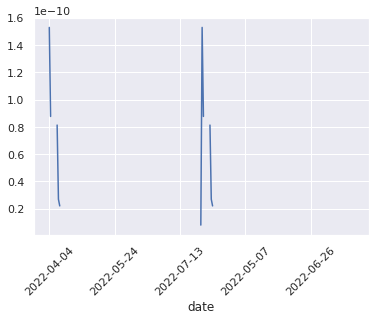

In [7]:
df.loc[(df['contractAddress'] == '0x55e558b46386521ecea9aca3634043d0c8458fbd')&(df['chain'] == 'ethereum')].set_index('date')['priceUSD'].plot(rot=45)
df.loc[(df['contractAddress'] == '0x55e558b46386521ecea9aca3634043d0c8458fbd')&(df['chain'] == 'ethereum')]

In [8]:
(2.699060e-11 - 8.131660e-11) / 8.131660e-11

-0.668080072211578

In [6]:
pd.set_option('display.max_rows', None)
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv')
it = pd.read_csv(f'{WD}/daily_transaction/list/panel.csv')
crashes = df.loc[(df['crash_0'] == 1)&(df['insider_trading'] == True)&(df['contractAddress'] == '0x55e558b46386521ecea9aca3634043d0c8458fbd')&(df['chain'] == 'ethereum')]
ret_0 = crashes['ret_0'].values[0]

# ret_0 # Check Return_0 

for _, row_crashes in crashes.drop_duplicates('date').iterrows():
    contractAddress = row_crashes['contractAddress']
    contractAddress_lower = contractAddress.lower()
    contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
    chain = row_crashes['chain']
    date = row_crashes['date']
    panel = row_crashes['panel']
    its = it.loc[((it['contractAddress'] == contractAddress_lower)&(it['date'] == date))|
                 ((it['contractAddress'] == contractAddress_upper)&(it['date'] == date))]
    dexes = {i for i in its['dex'].values}
    for dex in dexes:
        dex_num = 0
        lst = pd.read_csv(f'{WD}daily_transaction/list/{dex}.csv')
        status = lst.loc[(lst['contractaddress'] == contractAddress_lower)&(lst['date'] == date), 'status'].values[0]
        if status != -1:
            
            # Dex have data, not pancakeswap_binance.
            
            dex_num += 1
            t = pd.read_csv(f'{WD}daily_transaction/csv/{contractAddress_lower}_{date}_{dex}.csv')
            roles = {i for i in its.loc[its['dex'] == dex, 'panels'].values}
            for role in roles:
                priceImpacts = 0
                for _, row_its in its.loc[(its['dex'] == dex)&(its['panels'] == role)].iterrows():
                    # row_its
                    ID = row_its['id']
                    timestamp = row_its['timestamp']
                    token0_id = row_its['token0_id']
                    token1_id = row_its['token1_id']
                    amountUSD = row_its['amountUSD']
                    amount0Out = row_its['amount0Out']
                    amount0In = row_its['amount0In']
                    amount1Out = row_its['amount1Out']
                    amount1In = row_its['amount1In']
                    
                    if (token0_id == contractAddress_lower)|(token0_id == contractAddress_upper): tokenPrice = amountUSD / np.abs(amount0Out - amount0In)
                    else: tokenPrice = amountUSD / np.abs(amount1Out - amount1In)
                    
                    t.sort_values('timestamp', ascending=True, inplace=True)
                    row_its
                    t
                    last = t.loc[(t['timestamp'] < timestamp)].tail(1)
                    
                    # If the insider trading is the first transaction
                    
                    if len(last) != 0:
                        token0_id_last = last['token0_id'].values[0]
                        token1_id_last = last['token1_id'].values[0]
                        amountUSD_last = last['amountUSD'].values[0]
                        amount0Out_last = last['amount0Out'].values[0]
                        amount0In_last = last['amount0In'].values[0]
                        amount1Out_last = last['amount1Out'].values[0]
                        amount1In_last = last['amount1In'].values[0]

                        if (token0_id_last == contractAddress_lower)|(token0_id_last == contractAddress_upper): tokenPrice_last = amountUSD_last / np.abs(amount0Out_last - amount0In_last)
                        else: tokenPrice_last = amountUSD_last / np.abs(amount1Out_last - amount1In_last)

                    else:
                        
                        # If the priceUSD is nan, just leave it error
                        
                        date_last = (pd.to_datetime(date) - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
                        tokenPrice_last = df.loc[(df['date'] == date_last)&(df['contractAddress'] == contractAddress), 'priceUSD'].values[0]
                        tokenPrice_last, tokenPrice # Check price change
                        
                    priceImpact = (np.log(tokenPrice) - np.log(tokenPrice_last)) / ret_0
                    priceImpacts += priceImpact    
                        
                priceImpacts # Show Price Impacts
        else:
            print(f'{dex} have no daily transaction info')
            continue
            
    if dex_num == 0:
        print(f'{contractAddress}have no price data')
        continue

Unnamed: 0                                                                          869.0
amountUSD                                                                     2536.694612
id                   0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c-0
logIndex                                                                              220
origin                                                                                NaN
recipient                                                                             NaN
sender                                         0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                          NaN
tick                                                                                  NaN
timestamp                                                             2022-04-11 14:49:22
token0_name                                                                    Shibae Inu
token1_nam

,amount0In,amount0Out,amount1In,amount1Out,amountUSD,from,id,logIndex,to,timestamp,sender,token0_name,token1_name,token0_id,token1_id,transaction_id
0,4.712980e+13,0,0,0.999999,2826.988833,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2-0,279,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:48:34,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2
1,5.716810e+13,0,0,0.900000,2536.694612,0x1935a9c0472f0a3ccef14174264b592229828ddf,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c-0,220,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:49:22,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c
2,4.072010e+13,0,0,0.499999,1447.133500,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98-0,18,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:25,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98
3,5.345813e+13,0,0,0.532417,1527.221347,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a-0,385,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:51,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a


Unnamed: 0                                                                          870.0
amountUSD                                                                     2826.988833
id                   0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2-0
logIndex                                                                              279
origin                                                                                NaN
recipient                                                                             NaN
sender                                         0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                          NaN
tick                                                                                  NaN
timestamp                                                             2022-04-11 14:48:34
token0_name                                                                    Shibae Inu
token1_nam

,amount0In,amount0Out,amount1In,amount1Out,amountUSD,from,id,logIndex,to,timestamp,sender,token0_name,token1_name,token0_id,token1_id,transaction_id
0,4.712980e+13,0,0,0.999999,2826.988833,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2-0,279,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:48:34,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2
1,5.716810e+13,0,0,0.900000,2536.694612,0x1935a9c0472f0a3ccef14174264b592229828ddf,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c-0,220,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:49:22,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c
2,4.072010e+13,0,0,0.499999,1447.133500,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98-0,18,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:25,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98
3,5.345813e+13,0,0,0.532417,1527.221347,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a-0,385,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:51,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a


(8.13166e-11, 5.998304328316762e-11)

Unnamed: 0                                                                          871.0
amountUSD                                                                       1447.1335
id                   0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98-0
logIndex                                                                               18
origin                                                                                NaN
recipient                                                                             NaN
sender                                         0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                          NaN
tick                                                                                  NaN
timestamp                                                             2022-04-11 14:51:25
token0_name                                                                    Shibae Inu
token1_nam

,amount0In,amount0Out,amount1In,amount1Out,amountUSD,from,id,logIndex,to,timestamp,sender,token0_name,token1_name,token0_id,token1_id,transaction_id
0,4.712980e+13,0,0,0.999999,2826.988833,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2-0,279,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:48:34,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2
1,5.716810e+13,0,0,0.900000,2536.694612,0x1935a9c0472f0a3ccef14174264b592229828ddf,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c-0,220,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:49:22,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c
2,4.072010e+13,0,0,0.499999,1447.133500,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98-0,18,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:25,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98
3,5.345813e+13,0,0,0.532417,1527.221347,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a-0,385,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:51,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a


Unnamed: 0                                                                          872.0
amountUSD                                                                     1527.221347
id                   0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a-0
logIndex                                                                              385
origin                                                                                NaN
recipient                                                                             NaN
sender                                         0x7a250d5630b4cf539739df2c5dacb4c659f2488d
sqrtPriceX96                                                                          NaN
tick                                                                                  NaN
timestamp                                                             2022-04-11 14:51:51
token0_name                                                                    Shibae Inu
token1_nam

,amount0In,amount0Out,amount1In,amount1Out,amountUSD,from,id,logIndex,to,timestamp,sender,token0_name,token1_name,token0_id,token1_id,transaction_id
0,4.712980e+13,0,0,0.999999,2826.988833,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2-0,279,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:48:34,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xba267e6039e1f910792451e0a46c2c17a2403397703c7909f4ff2726b2a8dcb2
1,5.716810e+13,0,0,0.900000,2536.694612,0x1935a9c0472f0a3ccef14174264b592229828ddf,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c-0,220,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:49:22,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x6bbf0584824a7ff54894ed0b089ca63dc25fc7c727c853685b9dd3d176637d3c
2,4.072010e+13,0,0,0.499999,1447.133500,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98-0,18,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:25,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe2edac8e35d6a997d29e15ec1ba53dbf0f6996a12971837621b7c531f86e7c98
3,5.345813e+13,0,0,0.532417,1527.221347,0x1935a9c0472f0a3ccef14174264b592229828ddf,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a-0,385,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,2022-04-11 14:51:51,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Shibae Inu,Wrapped Ether,0x55e558b46386521ecea9aca3634043d0c8458fbd,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xe8a65c1381bc6990b9f1281733efd8ad887df931491f689c01f81f90f82d6c5a


0.9484814071431436

In [128]:
562.823350 / 1.448478e+09
0.074855 / 1.950619e+05
27.728034 / 7.175178e+07

344.831999 / 169008.677196
292444.085262/1000000000000000

3.8856189048090476e-07

3.8374997885286673e-07

3.864438485010407e-07

0.0020403212706061064

2.9244408526199997e-10

In [72]:
t = pd.read_csv(f'{WD}daily_transaction/csv/0x985572429deb3acc47e019af6b3da4620175e553_2022-02-12_uniswapv2_ethereum.csv')
t.sort_values('timestamp', ascending=True, inplace=True)
t
df.loc[(df['date'] == '2022-02-12')&(df['contractAddress'] == '0x985572429deb3acc47e019af6b3da4620175e553')]

FileNotFoundError: [Errno 2] No such file or directory: '/home/team_defi/03_wdata/daily_transaction/csv/0x985572429deb3acc47e019af6b3da4620175e553_2022-02-12_uniswapv2_ethereum.csv'

In [66]:
1125.801710 / 1.374200e+07
1757.638040 / 2.000000e+07
2182.845252 / 2.250000e+07

8.192415296172319e-05

8.788190200000001e-05

9.701534453333333e-05

In [ ]:
0.0007177815873445

In [55]:
54147.94 / 3000000000000
5.004000e-13

1.8049313333333335e-08

5.004e-13

In [56]:
np.log(1.8049313333333335e-08) - np.log(0.0007177815873445)

-10.590812964273729

In [57]:
np.log(5.004e-13) - np.log(0.0007177815873445)

-21.084023385225898

# Sell Probability

## Crash Old

In [81]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv')
df_crash = df.loc[(df['crash_0'] == 1)&(df['insider_sell'] == True)&df['insider_buy'] == False]
it = pd.read_csv(f'{WD}/daily_transaction/list/panel.csv')
dfs = []

for _, row_df_crash in df_crash.drop_duplicates(['contractAddress', 'chain']).iterrows():
    contractAddress = row_df_crash['contractAddress']
    contractAddress_lower = contractAddress.lower()
    contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
    chain = row_df_crash['chain']
    crashes = df_crash.loc[(df_crash['contractAddress'] == contractAddress)&(df_crash['chain'] == chain)]

    for _, row_crashes in crashes.drop_duplicates('date').iterrows():
        dfs_crash = []
        date = row_crashes['date']
        its = it.loc[((it['contractAddress'] == contractAddress_lower)&(it['date'] == date))|
                     ((it['contractAddress'] == contractAddress_upper)&(it['date'] == date))]
        its.sort_values('timestamp', ascending=True, inplace=True)
        dexes = {i for i in its['dex'].values}
        dex_num = 0
        for dex in dexes:
            dfs_dex = []
            lst = pd.read_csv(f'{WD}daily_transaction/list/{dex}.csv')
            status = lst.loc[(lst['contractaddress'] == contractAddress_lower)&(lst['date'] == date), 'status'].values[0]
            if status != -1:
                dex_num += 1
                t = pd.read_csv(f'{WD}daily_transaction/csv/{contractAddress_lower}_{date}_{dex}.csv')
                t.sort_values('timestamp', ascending=True, inplace=True)

                t['lp'] = np.nan
                for _, row_t in t.iterrows():
                    transaction_id_t = row_t['transaction_id']
                    try:
                        status = liquidity_provision(transaction_id_t, chain)
                        if status == True:
                            t.loc[t['transaction_id'] == transaction_id_t, 'lp'] = True
                        else:
                            t.loc[t['transaction_id'] == transaction_id_t, 'lp'] = False
                    except Exception as e:
                        print(f'error:{e}')

                t = t.loc[t['lp'] == False]
                t['insider_contractAddress'] = contractAddress
                t = set_buy(df=t)
                t = t.reset_index(drop=True).reset_index()

                for i in range(1, 10):
                    t[f'sell_{i}'] = np.nan

                for _, row_t in t.iterrows():
                    transaction_id_t = row_t['transaction_id']
                    index_t = row_t['index']
                    for i in range(1, 10):
                        if t.loc[t['index'] == index_t + i].shape[0] == 0: continue
                        if t.loc[t['index'] == index_t + i, 'buy'].values[0] < 0: t.loc[t['index'] == index_t, f'sell_{i}'] = 1
                        if t.loc[t['index'] == index_t + i, 'buy'].values[0] > 0: t.loc[t['index'] == index_t, f'sell_{i}'] = 0    
                roles = {i for i in its.loc[its['dex'] == dex, 'panels'].values}
                dfs_role = []
                for role in roles:
                    role_t = t.copy()
                    role_t['panels'] = role
                    role_t['dex'] = dex
                    role_id = its.loc[its['panels'] == role].head(1)['id'].values[0]
                    it_index = role_t.loc[role_t['id'] == role_id, 'index'].values[0]
                    role_t['after'] = False
                    after = role_t.loc[role_t['index'] > it_index, 'after'] = True
                    dfs_role.append(role_t)
                dfs_role = pd.concat(dfs_role)
                dfs_dex.append(dfs_role)
            else:
                print('No data')
                continue
        if dex_num != 0:
            dfs_dex = pd.concat(dfs_dex)   
            dfs_crash.append(dfs_dex)
    if dex_num != 0:    
        dfs_crash = pd.concat(dfs_crash)
        dfs.append(dfs_crash)
        print(f'{role} of {contractAddress} on {chain} at {date} done')
    
dfs = pd.concat(dfs)
dfs

KeyboardInterrupt: 

## Example

In [11]:
df = pd.read_csv(f'{WD}token_ret_new/lst/panel_crash_old.csv')
it = pd.read_csv(f'{WD}/daily_transaction/list/panel.csv')
df.loc[(df['crash_0'] == 1)&(df['insider_sell'] == True)&(df['insider_buy'] == False)&(df['panel'] == 'root')].sample(1)

,date,contractAddress,chain,ret_-5,ret_-4,ret_-3,ret_-2,ret_-1,ret_0,ret_1,ret_2,ret_3,ret_4,ret_5,priceUSD,panel,insider_trading,insider_buy,insider_sell,twitter,event_date_-5,event_date_-4,event_date_-3,event_date_-2,event_date_-1,event_date_0,event_date_1,event_date_2,event_date_3,event_date_4,event_date_5,crash_new,crash_-5,crash_-4,crash_-3,crash_-2,crash_-1,crash_0,crash_1,crash_2,crash_3,crash_4,crash_5
24083,2022-02-08,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,ethereum,NaN,NaN,2.832361,0.036031,0.163096,-3.033312,0.27629,0.026499,NaN,NaN,NaN,0.00008,root,True,False,True,2,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1,0,0,0,0,0


In [51]:
ID = '0x381fbe0c8825b205a56f0f3579e4c2d11071bbb34bba571937f1db07d72f9559-0'
contractAddress = '0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4'
contractAddress_lower = contractAddress.lower()
contractAddress_upper = Web3.toChecksumAddress(contractAddress_lower)
chain = 'ethereum'
date = '2022-02-08'
panel = 'root'
its = it.loc[((it['contractAddress'] == contractAddress_lower)&(it['date'] == date))|
             ((it['contractAddress'] == contractAddress_upper)&(it['date'] == date))]
its.sort_values('timestamp', ascending=True, inplace=True)
dexes = {i for i in its['dex'].values}
for dex in dexes:
    dex_num = 0
    lst = pd.read_csv(f'{WD}daily_transaction/list/{dex}.csv')
    status = lst.loc[(lst['contractaddress'] == contractAddress_lower)&(lst['date'] == date), 'status'].values[0]
    if status != -1:
        dex_num += 1
        t = pd.read_csv(f'{WD}daily_transaction/csv/{contractAddress_lower}_{date}_{dex}.csv')
        t.sort_values('timestamp', ascending=True, inplace=True)
        
        t['lp'] = np.nan
        for _, row_t in t.iterrows():
            transaction_id_t = row_t['transaction_id']
            try:
                status = liquidity_provision(transaction_id_t, chain)
                if status == True:
                    t.loc[t['transaction_id'] == transaction_id_t, 'lp'] = True
                else:
                    t.loc[t['transaction_id'] == transaction_id_t, 'lp'] = False
            except Exception as e:
                print(f'error:{e}')
                
        t = t.loc[t['lp'] == False]
        t['insider_contractAddress'] = contractAddress
        t = set_buy(df=t)
        t = t.reset_index(drop=True).reset_index()
        
        for i in range(1, 10):
            t[f'sell_{i}'] = np.nan
        
        for _, row_t in t.iterrows():
            transaction_id_t = row_t['transaction_id']
            index_t = row_t['index']
            for i in range(1, 10):
                if t.loc[t['index'] == index_t + i].shape[0] == 0: continue
                if t.loc[t['index'] == index_t + i, 'buy'].values[0] < 0: t.loc[t['index'] == index_t, f'sell_{i}'] = 1
                if t.loc[t['index'] == index_t + i, 'buy'].values[0] > 0: t.loc[t['index'] == index_t, f'sell_{i}'] = 0    
        roles = {i for i in its.loc[its['dex'] == dex, 'panels'].values}
        dfs = []
        for role in roles:
            role_t = t.copy()
            role_t['panels'] = role
            role_id = its.loc[its['panels'] == role].head(1)['id'].values[0]
            it_index = role_t.loc[role_t['id'] == role_id, 'index'].values[0]
            role_t['after'] = False
            after = role_t.loc[role_t['index'] > it_index, 'after'] = True
            dfs.append(role_t)
        dfs = pd.concat(dfs)
        dfs

,index,amount0In,amount0Out,amount1In,amount1Out,amountUSD,from,id,logIndex,to,timestamp,sender,token0_name,token1_name,token0_id,token1_id,transaction_id,lp,insider_contractAddress,buy,sell_1,sell_2,sell_3,sell_4,sell_5,sell_6,sell_7,sell_8,sell_9,panels,after
0,0,0.000000e+00,1.864868e+06,1.000000,0.000000,3156.060199,0xcbd569f850c94e93d6dce88caa88e0767aa75216,0xa014d400f3519d35cd8a848d9331153d29c35b926aaf9fdb50bffe18a7c2fe26-0,111,0xcbd569f850c94e93d6dce88caa88e0767aa75216,2022-02-08 00:51:56,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa014d400f3519d35cd8a848d9331153d29c35b926aaf9fdb50bffe18a7c2fe26,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,3156.060199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,root,False
1,1,0.000000e+00,9.135182e+04,0.050000,0.000000,156.482992,0xbbb8a0fac9e97f6615ece21a01ca42eddc06b587,0xd61faded03d7b598fad933dfa1dec3853163e0bf4b061fd18de6f7d80ce11b66-0,224,0xbbb8a0fac9e97f6615ece21a01ca42eddc06b587,2022-02-08 01:06:35,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd61faded03d7b598fad933dfa1dec3853163e0bf4b061fd18de6f7d80ce11b66,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,156.482992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,root,False
2,2,0.000000e+00,5.748098e+03,0.003149,0.000000,9.851045,0x1886fdb4e39c61cdaf8d61f9c20bd36c10d9eb18,0x32fc53404bb6db7e8f94b715eba225dc6ff3d385deef2c04d7557d2cb44084a4-0,42,0xe66b31678d6c16e9ebf358268a790b763c133750,2022-02-08 01:25:59,0xdef1c0ded9bec7f1a1670819833240f027b25eff,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x32fc53404bb6db7e8f94b715eba225dc6ff3d385deef2c04d7557d2cb44084a4,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,9.851045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,root,False
3,3,0.000000e+00,5.471986e+04,0.030000,0.000000,93.945054,0xf16120907a6fde0611f5680f2563f0a2c62f7949,0x2b50cafcd665a0aa126da5d16d757406977fa809f4e49429d9f1f707792644f1-0,286,0xf16120907a6fde0611f5680f2563f0a2c62f7949,2022-02-08 01:30:12,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2b50cafcd665a0aa126da5d16d757406977fa809f4e49429d9f1f707792644f1,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,93.945054,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,root,False
4,4,0.000000e+00,5.465659e+04,0.030000,0.000000,93.958153,0xf16120907a6fde0611f5680f2563f0a2c62f7949,0x41c6ba934e3cc25429042660131828bb77a7f9b868eb06f7c2ee4d6c166e2e43-0,63,0xf16120907a6fde0611f5680f2563f0a2c62f7949,2022-02-08 01:30:45,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x41c6ba934e3cc25429042660131828bb77a7f9b868eb06f7c2ee4d6c166e2e43,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,93.958153,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,root,False
5,5,0.000000e+00,9.017401e+05,0.500000,0.000000,1574.068719,0xec41763086204042ba22e0938a90463461d68868,0x01ba43c60e4696ad470bdfb0a55c07becbc17321087a0fb1e6ba544c41a7309f-0,96,0xec41763086204042ba22e0938a90463461d68868,2022-02-08 01:37:30,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x01ba43c60e4696ad470bdfb0a55c07becbc17321087a0fb1e6ba544c41a7309f,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,1574.068719,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,root,False
6,6,0.000000e+00,7.139530e+04,0.040000,0.000000,125.382085,0xd30ce125f5375a678279a3dd637853ee54cc50d9,0x2345197dea683e30fa4107637c36fdbaa2e6abb97eea56d976d951444d7be53e-0,239,0xd30ce125f5375a678279a3dd637853ee54cc50d9,2022-02-08 01:39:03,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aa

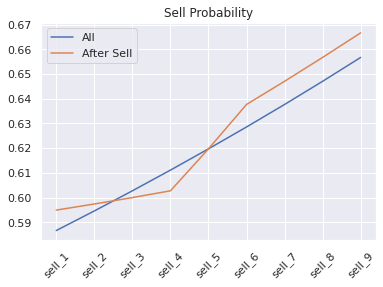

In [54]:
sell_info = [f'sell_{i}' for i in range(1, 10)]

all_mean = [dfs[i].mean() for i in sell_info]

after = dfs.loc[dfs['after'] == True].copy()
after_mean = [after[i].mean() for i in sell_info]

fig, ax = plt.subplots()
_ = ax.plot(sell_info, all_mean, label='All')
_ = ax.plot(sell_info, after_mean, label='After Sell')
_ = ax.set_title(f'Sell Probability')

_ = plt.xticks(rotation=45)
plt.legend()
plt.show()

In [47]:
pd.set_option('display.max_rows', None)
t 

,index,amount0In,amount0Out,amount1In,amount1Out,amountUSD,from,id,logIndex,to,timestamp,sender,token0_name,token1_name,token0_id,token1_id,transaction_id,lp,insider_contractAddress,buy,sell_1,sell_2,sell_3,sell_4,sell_5,sell_6,sell_7,sell_8,sell_9
0,0,0.000000e+00,1.864868e+06,1.000000,0.000000,3156.060199,0xcbd569f850c94e93d6dce88caa88e0767aa75216,0xa014d400f3519d35cd8a848d9331153d29c35b926aaf9fdb50bffe18a7c2fe26-0,111,0xcbd569f850c94e93d6dce88caa88e0767aa75216,2022-02-08 00:51:56,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xa014d400f3519d35cd8a848d9331153d29c35b926aaf9fdb50bffe18a7c2fe26,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,3156.060199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.000000e+00,9.135182e+04,0.050000,0.000000,156.482992,0xbbb8a0fac9e97f6615ece21a01ca42eddc06b587,0xd61faded03d7b598fad933dfa1dec3853163e0bf4b061fd18de6f7d80ce11b66-0,224,0xbbb8a0fac9e97f6615ece21a01ca42eddc06b587,2022-02-08 01:06:35,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0xd61faded03d7b598fad933dfa1dec3853163e0bf4b061fd18de6f7d80ce11b66,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,156.482992,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.000000e+00,5.748098e+03,0.003149,0.000000,9.851045,0x1886fdb4e39c61cdaf8d61f9c20bd36c10d9eb18,0x32fc53404bb6db7e8f94b715eba225dc6ff3d385deef2c04d7557d2cb44084a4-0,42,0xe66b31678d6c16e9ebf358268a790b763c133750,2022-02-08 01:25:59,0xdef1c0ded9bec7f1a1670819833240f027b25eff,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x32fc53404bb6db7e8f94b715eba225dc6ff3d385deef2c04d7557d2cb44084a4,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,9.851045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,3,0.000000e+00,5.471986e+04,0.030000,0.000000,93.945054,0xf16120907a6fde0611f5680f2563f0a2c62f7949,0x2b50cafcd665a0aa126da5d16d757406977fa809f4e49429d9f1f707792644f1-0,286,0xf16120907a6fde0611f5680f2563f0a2c62f7949,2022-02-08 01:30:12,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2b50cafcd665a0aa126da5d16d757406977fa809f4e49429d9f1f707792644f1,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,93.945054,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
4,4,0.000000e+00,5.465659e+04,0.030000,0.000000,93.958153,0xf16120907a6fde0611f5680f2563f0a2c62f7949,0x41c6ba934e3cc25429042660131828bb77a7f9b868eb06f7c2ee4d6c166e2e43-0,63,0xf16120907a6fde0611f5680f2563f0a2c62f7949,2022-02-08 01:30:45,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x41c6ba934e3cc25429042660131828bb77a7f9b868eb06f7c2ee4d6c166e2e43,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,93.958153,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,5,0.000000e+00,9.017401e+05,0.500000,0.000000,1574.068719,0xec41763086204042ba22e0938a90463461d68868,0x01ba43c60e4696ad470bdfb0a55c07becbc17321087a0fb1e6ba544c41a7309f-0,96,0xec41763086204042ba22e0938a90463461d68868,2022-02-08 01:37:30,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x01ba43c60e4696ad470bdfb0a55c07becbc17321087a0fb1e6ba544c41a7309f,False,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,1574.068719,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
6,6,0.000000e+00,7.139530e+04,0.040000,0.000000,125.382085,0xd30ce125f5375a678279a3dd637853ee54cc50d9,0x2345197dea683e30fa4107637c36fdbaa2e6abb97eea56d976d951444d7be53e-0,239,0xd30ce125f5375a678279a3dd637853ee54cc50d9,2022-02-08 01:39:03,0x68b3465833fb72a70ecdf485e0e4c7bd8665fc45,Magic Inu,Wrapped Ether,0xabf4b85b7110687ccda8c1299a7ddd2b5fc06ad4,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,0x2345197dea683e30fa4107637c36fdbaa2e6abb97